<a href="https://colab.research.google.com/github/nicikess/hsg-nlp-course/blob/main/Part_I_Data_Collection_%26_Preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Semantic Code Search using Transformers and BERT - Part I 
Author - Shashank Ramesh

<b>Objective</b> - To summarize we would be building a search engine which would take input a search query, find a function from a large pool of source code which implements the functionality semantically matching what is being queried.

<img src="images/2.png" />

In Part-I of the series where we discuss on gathering the data for training our model and preprocessing the raw data to make it useful for our models to gather insights from.

## Data Collection and Preprocessing
This notebook contains steps to gather the data for training our model and preprocessing the raw data to make it useful for our models to gather insights from.

In [4]:
#importing libraries

import ast
import sqlite3

import glob
import re
from pathlib import Path

import astor
import pandas as pd
from nltk.tokenize import RegexpTokenizer
from sklearn.model_selection import train_test_split

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Collecting Data
The data required for making our semantic search engine is large code bases which are made publicly available by GitHub on this [link](https://storage.googleapis.com/kubeflow-examplescode_search/raw_data/000000000000.csv). 

There are 10 such files which can be downloaded by changing the last digit to its successor in the [link](https://storage.googleapis.com/kubeflow-examplescode_search/raw_data/000000000000.csv). The data set contains code from repositories of diverse domains and can help in building a general purpose search engine.

Once downloaded we get a corpus of data containing 12,41,664 files and we can use the below snippet to read all the files.

In [6]:
%%time
# Read the data into a pandas dataframe, and parse out some meta-data
path_data = '/content/drive/MyDrive/NLP/data/raw/'

df_list = list()

for i in range(10):
  df = pd.read_csv(path_data + f'00000000000{i}.csv')
  df['nwo'] = df['repo_path'].apply(lambda r: r.split()[0]) # Get the name of repository with the owner name
  df['path'] = df['repo_path'].apply(lambda r: r.split()[1]) # Path to the code file in the repository
  df.drop(columns=['repo_path'], inplace=True)
  df = df[['nwo', 'path', 'content']]
  df_list.append(df)

CPU times: user 1min 6s, sys: 12.4 s, total: 1min 19s
Wall time: 1min 55s


In [ ]:
df.head()

,nwo,path,content
0,bitsanity/rateboard,krakenticker.py,#!/usr/bin/python\n# -*- coding: utf-8 -*-\n\n...
1,rusty1s/embedded_gcnn,lib/tf/convert.py,import numpy as np\nimport tensorflow as tf\n\...
2,mackorone/mms,util/ttf2png.py,import os\nimport sys\nimport string\n\ndef en...
3,nicksergeant/snipt,accounts/models.py,from annoying.functions import get_object_or_N...
4,huaxz1986/git_book,chapters/Model_Selection/validation_curve.py,"# -*- coding: utf-8 -*-\n""""""\n 模型选择\n ~~..."


In [ ]:
# Inspect shape of the raw data
df.shape

(123998, 3)

### Extracting (Function,Docstring) Pairs 

Our goal is to parse the python files into (function, docstring) pairs. 

For this task we will be using the AST library which just as python compilers converts the source code into an abstract syntax tree for analysis. It identifies all different components in the source code and helps us extract them for processing. 

We are interested in extracting the function definitions along with its corresponding docstring removing other information like comments, decorators and function signatures. After we extract the function definition and its docstring we tokenize each of them to remove punctuation, decorators and convert all the tokens to lower case.

In [7]:
def tokenize_docstring(text):
    """Gets filetered docstring tokens which help describe the function"""
    
    # Remove decorators and other parameter signatures in the docstring
    before_keyword, keyword, after_keyword = text.partition(':')
    before_keyword, keyword, after_keyword = before_keyword.partition('@param')
    before_keyword, keyword, after_keyword = before_keyword.partition('param')
    before_keyword, keyword, after_keyword = before_keyword.partition('@brief')
    
    if(after_keyword):    
        words = RegexpTokenizer(r'[a-zA-Z0-9]+').tokenize(after_keyword)
    else:
        before_keyword, keyword, after_keyword = before_keyword.partition('@')
        words = RegexpTokenizer(r'[a-zA-Z0-9]+').tokenize(before_keyword)
        
    # Convert all docstrings to lowercase
    new_words= [word.lower() for word in words if word.isalnum()]
    
    return new_words


def tokenize_code(text):
    """Gets filetered fucntion tokens"""
    
    # Remove decorators and function signatures till the def token
    keyword = 'def '
    before_keyword, keyword, after_keyword = text.partition(keyword)
    words = RegexpTokenizer(r'[a-zA-Z0-9]+').tokenize(after_keyword)
    
    # Convert function tokens to lowercase and remove single alphabet variables
    new_words= [word.lower() for word in words if (word.isalpha() and len(word)>1) or (word.isnumeric())]
    return new_words


def get_function_docstring_pairs(blob):
    "Extracts (function/method, docstring) pairs from a given code blob."
    
    pairs = []
    try:
        module = ast.parse(blob) # Converts the python code into an abstract syntx tree
        classes = [node for node in module.body if isinstance(node, ast.ClassDef)] # Retrieves classes from source code
        functions = [node for node in module.body if isinstance(node, ast.FunctionDef)] # Retrieves functions from the source code
        for _class in classes:
            functions.extend([node for node in _class.body if isinstance(node, ast.FunctionDef)]) # Retrieves functions from the classes extracted

        for f in functions:
            source = astor.to_source(f) # Convert the functions extracted into ast format so as to remove comments
            docstring = ast.get_docstring(f) if ast.get_docstring(f) else '' # Get docstring from fucntion definition if present
            function = source.replace(ast.get_docstring(f, clean=False), '') if docstring else source # function definition without any comments
            
            # Extracts function name, line number of the function in the source code, original function, function tokens and docstring tokens 
            pairs.append((f.name,         
                          f.lineno,
                          source,
                          ' '.join(tokenize_code(function)),
                          ' '.join(tokenize_docstring(docstring.split('\n\n')[0]))
                         ))
    except (AssertionError, MemoryError, SyntaxError, UnicodeEncodeError):
        pass
    return pairs


def get_function_docstring_pairs_list(blob_list):
    """apply the function `get_function_docstring_pairs` on a list of blobs"""
    return [get_function_docstring_pairs(b) for b in blob_list]

<img src="images/1.png" />

In [8]:
func_doc_list = list()

In [15]:
df = get_function_docstring_pairs_list(df_list[0].content.tolist())


In [17]:
print(*df)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



KeyboardInterrupt: ignored

Exception ignored in: 'zmq.backend.cython.message.Frame.__dealloc__'
Traceback (most recent call last):
  File "zmq/backend/cython/checkrc.pxd", line 13, in zmq.backend.cython.checkrc._check_rc
KeyboardInterrupt
IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 [] [] [('setup_dependent_environment', 53, "def setup_dependent_environment(self, build_env, run_env, dep_spec):\n    build_env.prepend_path('LD_LIBRARY_PATH', self.prefix.lib)\n", 'setup dependent environment self build env run env dep spec build env prepend path ld library path self prefix lib', ''), ('cmake_args', 62, "def cmake_args(self):\n    return ['-DBUILD_SHARED_LIBS:BOOL=ON']\n", 'cmake args self return dbuild shared libs bool on', '')] [('identity_block', 55, 'def identity_block(block, *args, **kwargs):\n    return block\n', 'identity block block args kwargs return block', ''), ('rename_sequence', 58, "def rename_sequence(hdr, name):\n    hdr['name'] = name\n    return hdr\n", 'rename sequence hdr name hdr name name return hdr', ''), ('__init__', 37, 'def __init__(self, iring, seq_callback, data_callback, data_ref=None, *args,\n    **kwargs):\n    super(CallbackBlock, self).__init__(iring, *args, **kwargs)\n    self.seq_callback = seq_callback\n    self.data_callback = dat

In [16]:
import csv

with open('one', 'w') as f:
      
    # using csv.writer method from CSV package
    write = csv.writer(f)
      
    write.writerow(fields)
    write.writerows(rows)

AttributeError: ignored

In [ ]:
func_doc_list.append(get_function_docstring_pairs_list(df_list[1].content.tolist()))
func_doc_list[1].to_csv('list_1.csv')

In [ ]:
func_doc_list.append(get_function_docstring_pairs_list(df_list[2].content.tolist()))
func_doc_list[2].to_csv('list_2.csv')

In [ ]:
func_doc_list.append(get_function_docstring_pairs_list(df_list[3].content.tolist()))
func_doc_list[3].to_csv('list_3.csv')

In [ ]:
func_doc_list.append(get_function_docstring_pairs_list(df_list[4].content.tolist()))
func_doc_list[4].to_csv('list_4.csv')

In [ ]:
func_doc_list.append(get_function_docstring_pairs_list(df_list[5].content.tolist()))
func_doc_list[5].to_csv('list_5.csv')

In [ ]:
func_doc_list.append(get_function_docstring_pairs_list(df_list[6].content.tolist()))
func_doc_list[6].to_csv('list_6.csv')

In [ ]:
func_doc_list.append(get_function_docstring_pairs_list(df_list[7].content.tolist()))
func_doc_list[7].to_csv('list_7.csv')

In [ ]:
func_doc_list.append(get_function_docstring_pairs_list(df_list[8].content.tolist()))
func_doc_list[8].to_csv('list_8.csv')

In [ ]:
func_doc_list.append(get_function_docstring_pairs_list(df_list[9].content.tolist()))
func_doc_list[9].to_csv('list_9.csv')

In [ ]:
len(func_doc_list)

In [2]:
df = pd.concat(func_doc_list, axis=0, ignore_index=True)

NameError: ignored

In [1]:
df.head()

NameError: ignored

In [ ]:
len(func_doc) 

123998

In [ ]:
# The dataset containing a the name of the directory, its path, source code, and all the functions in a list extracted from the source code
df['pairs'] = func_doc
df.head()

,nwo,path,content,pairs
0,bitsanity/rateboard,krakenticker.py,#!/usr/bin/python\n# -*- coding: utf-8 -*-\n\n...,[]
1,rusty1s/embedded_gcnn,lib/tf/convert.py,import numpy as np\nimport tensorflow as tf\n\...,"[(sparse_to_tensor, 5, def sparse_to_tensor(va..."
2,mackorone/mms,util/ttf2png.py,import os\nimport sys\nimport string\n\ndef en...,"[(end_of_path_index, 5, def end_of_path_index(..."
3,nicksergeant/snipt,accounts/models.py,from annoying.functions import get_object_or_N...,"[(get_blog_posts, 84, def get_blog_posts(self)..."
4,huaxz1986/git_book,chapters/Model_Selection/validation_curve.py,"# -*- coding: utf-8 -*-\n""""""\n 模型选择\n ~~...","[(test_validation_curve, 17, def test_validati..."


### Preparing the dataset
Once we have extracted our function-docstring pairs and their tokens which are free from decorators and other unwanted elements,we stack our findings in a data-frame with every row containing details about a function and its corresponding docstring.

In [ ]:
%%time
# flatten pairs
df = df.set_index(['nwo', 'path'])['pairs'].apply(pd.Series).stack()
df = df.reset_index()
df.columns = ['nwo', 'path', '_', 'pair']

CPU times: user 48.8 s, sys: 2.53 s, total: 51.3 s
Wall time: 49.5 s


In [ ]:
df.head()

,nwo,path,_,pair
0,rusty1s/embedded_gcnn,lib/tf/convert.py,0,"(sparse_to_tensor, 5, def sparse_to_tensor(val..."
1,mackorone/mms,util/ttf2png.py,0,"(end_of_path_index, 5, def end_of_path_index(f..."
2,mackorone/mms,util/ttf2png.py,1,"(get_path, 8, def get_path(full_path):\n re..."
3,mackorone/mms,util/ttf2png.py,2,"(get_name, 11, def get_name(full_path):\n r..."
4,mackorone/mms,util/ttf2png.py,3,"(ttf2png, 14, def ttf2png(chars_path, font_pat..."


In [ ]:
%%time
# gathering all detailes about the function and its corresponding docstring
df['function_name'] = df['pair'].apply(lambda p: p[0])
df['lineno'] = df['pair'].apply(lambda p: p[1])
df['original_function'] = df['pair'].apply(lambda p: p[2])
df['function_tokens'] = df['pair'].apply(lambda p: p[3])
df['docstring_tokens'] = df['pair'].apply(lambda p: p[4])
df = df[['nwo', 'path', 'function_name', 'lineno', 'original_function', 'function_tokens', 'docstring_tokens']]
df['url'] = df[['nwo', 'path', 'lineno']].apply(lambda x: 'https://github.com/{}/blob/master/{}#L{}'.format(x[0], x[1], x[2]), axis=1)

CPU times: user 12.2 s, sys: 118 ms, total: 12.3 s
Wall time: 14.7 s


In [ ]:
df.head()

,nwo,path,function_name,lineno,original_function,function_tokens,docstring_tokens,url
0,rusty1s/embedded_gcnn,lib/tf/convert.py,sparse_to_tensor,5,"def sparse_to_tensor(value):\n """"""Convert a...",sparse to tensor value row np reshape value ro...,convert a scipy sparse matrix to a tensorflow ...,https://github.com/rusty1s/embedded_gcnn/blob/...
1,mackorone/mms,util/ttf2png.py,end_of_path_index,5,def end_of_path_index(full_path):\n return ...,end of path index full path return full path r...,,https://github.com/mackorone/mms/blob/master/u...
2,mackorone/mms,util/ttf2png.py,get_path,8,def get_path(full_path):\n return full_path...,get path full path return full path end of pat...,,https://github.com/mackorone/mms/blob/master/u...
3,mackorone/mms,util/ttf2png.py,get_name,11,def get_name(full_path):\n return full_path...,get name full path return full path end of pat...,,https://github.com/mackorone/mms/blob/master/u...
4,mackorone/mms,util/ttf2png.py,ttf2png,14,"def ttf2png(chars_path, font_path, dest_path):...",chars path font path dest path options backgro...,,https://github.com/mackorone/mms/blob/master/u...


### Removing Duplicates
All entries which were duplicates with respect to function definitions or function tokens were removed

In [ ]:
%%time
# remove observations where the same function definition appears more than once
before_dedup = len(df)
df = df.drop_duplicates(['original_function'])
after_dedup = len(df)

print(f'Removed {before_dedup - after_dedup:,} duplicate rows')

Removed 38,409 duplicate rows
CPU times: user 1.34 s, sys: 5.97 ms, total: 1.35 s
Wall time: 1.56 s


In [ ]:
%%time
# remove observations which have the same function tokens appears more than once
before_dedup = len(df)
df = df.drop_duplicates(['function_tokens'])
after_dedup = len(df)

print(f'Removed {before_dedup - after_dedup:,} duplicate rows')

Removed 9,978 duplicate rows
CPU times: user 854 ms, sys: 6.93 ms, total: 861 ms
Wall time: 802 ms


In [ ]:
df.shape

(611875, 8)

### Separate function without docstrings


In [ ]:
def listlen(x):
    if not isinstance(x, list):
        return 0
    return len(x)

# separate functions without docstrings
# docstrings should be at least 3 words in the docstring to be considered a valid docstring

with_docstrings = df[df.docstring_tokens.str.split().apply(listlen) >= 3]
without_docstrings = df[df.docstring_tokens.str.split().apply(listlen) < 3]
print('Number of Funtion Snippets with docstring',len(with_docstrings))
print('Number of Funtion Snippets without docstring',len(without_docstrings))

Number of Funtion Snippets with docstring 143373
Number of Funtion Snippets without docstring 468502


In [ ]:
# Save the dataset of functions with docstrings
with_docstrings.to_csv('processed_full.csv')

In [ ]:
# Using SQLlite to analyse the dataset
conn = sqlite3.connect('with_docstrings.sqlite')
c=conn.cursor()
conn.text_factory = str
with_docstrings.to_sql('Data', conn, schema=None, if_exists='replace', index=True, index_label=None, chunksize=None, dtype=None)

In [ ]:
with_docstrings.head()

,nwo,path,function_name,lineno,original_function,function_tokens,docstring_tokens,url
0,rusty1s/embedded_gcnn,lib/tf/convert.py,sparse_to_tensor,5,"def sparse_to_tensor(value):\n """"""Convert a...",sparse to tensor value row np reshape value ro...,convert a scipy sparse matrix to a tensorflow ...,https://github.com/rusty1s/embedded_gcnn/blob/...
13,huaxz1986/git_book,chapters/Model_Selection/validation_curve.py,test_validation_curve,17,"def test_validation_curve():\n """"""\n 测试 ...",test validation curve digits load digits digit...,validation curve linearsvc c,https://github.com/huaxz1986/git_book/blob/mas...
14,xuleiboy1234/autoTitle,tensorflow/tensorflow/contrib/cloud/python/ops...,_ConvertRowToExampleProto,77,"def _ConvertRowToExampleProto(row):\n """"""Co...",convertrowtoexampleproto row example example e...,converts the input row to an example proto,https://github.com/xuleiboy1234/autoTitle/blob...
15,xuleiboy1234/autoTitle,tensorflow/tensorflow/contrib/cloud/python/ops...,_SetUpQueue,172,"def _SetUpQueue(reader):\n """"""Sets up a que...",setupqueue reader queue data flow ops fifoqueu...,sets up a queue for a reader,https://github.com/xuleiboy1234/autoTitle/blob...
16,xuleiboy1234/autoTitle,tensorflow/tensorflow/contrib/cloud/python/ops...,__init__,104,"def __init__(self, address, port):\n """"""Cre...",init self address port threading thread init s...,creates a fakebigqueryserver,https://github.com/xuleiboy1234/autoTitle/blob...


In [ ]:
# Number of unique repositories
print("Number of repositories -",len(list(set(with_docstrings['nwo']))))

In [ ]:
# Getting the count of function tokens per function
with_docstrings['function_tokens_count'] = [len(item.split()) for item in list(with_docstrings['function_tokens'].values)]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
len(with_docstrings['function_tokens_count'] .values)

143373

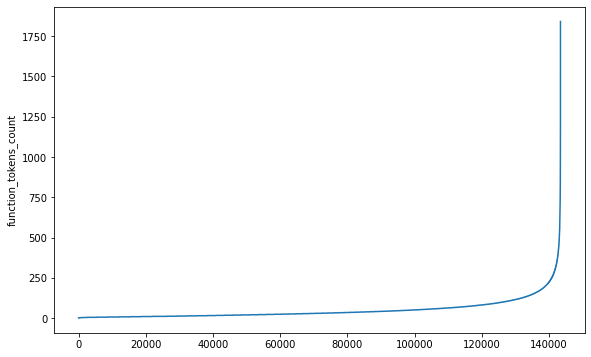

In [ ]:
import matplotlib.pyplot as plt
# Plotting the graph of sorted list of function tokens
plt.plot(sorted(list(with_docstrings['function_tokens_count'] .values)))
plt.ylabel('function_tokens_count')
plt.rcParams['figure.figsize'] = [9.5, 6]
plt.show()

In [ ]:
# Analysing what must be the minimum count of function tokens by seeing the values returned in sql queries
# KN: Error probably because of remove favor in cell 27

#final = pd.read_sql_query("""
#SELECT *
#FROM Data
#WHERE function_tokens_count > 4
#ORDER BY function_tokens_count
#""", conn)
#final[:20]

In [ ]:
final.shape

(143373, 9)

In [ ]:
conn = sqlite3.connect('with_docstrings.sqlite')
c=conn.cursor()
conn.text_factory = str
final.to_sql('Modified', conn, schema=None, if_exists='replace', index=True, index_label=None, chunksize=None, dtype=None)

In [ ]:
# checking if functions which are overridden are of importance to us
#check = pd.read_sql_query("""
#SELECT *
#FROM Modified
#WHERE function_name LIKE '!_!_%' ESCAPE'!'
#ORDER BY function_tokens_count
#""", conn)
#check.head()

In [ ]:
final.to_csv('processed_full2.csv')

## Train-Validation-Test Split
It was decided not to randomly split the data set instead to group the entries according to the repositories they belong and then split the data set. 

In [ ]:
#Grouping entries by thie repository name
grouped = final.groupby('nwo')

In [ ]:
# train, valid, test splits
train, valid = train_test_split(list(grouped), train_size=0.9, random_state=8081)
train, test = train_test_split(train, train_size=0.9, random_state=8081)

In [ ]:
train = pd.concat([d for _, d in train]).reset_index(drop=True)
valid = pd.concat([d for _, d in valid]).reset_index(drop=True)
test = pd.concat([d for _, d in test]).reset_index(drop=True)

In [ ]:
print(f'train set num rows {train.shape[0]:,}')
print(f'valid set num rows {valid.shape[0]:,}')
print(f'test set num rows {test.shape[0]:,}')
print(f'without docstring rows {without_docstrings.shape[0]:,}')

train set num rows 116,109
valid set num rows 14,573
test set num rows 12,691
without docstring rows 468,502


Preview what the training set looks like.  You can start to see how the data looks, the function tokens and docstring tokens are what will be fed downstream into the models.  The other information is important for diagnostics and bookeeping.

In [ ]:
train.head()

,index,nwo,path,function_name,lineno,original_function,function_tokens,docstring_tokens,url
0,88320,vmagamedov/hiku,hiku/compat.py,with_metaclass,11,"def with_metaclass(meta, *bases):\n """"""Crea...",with metaclass meta bases class metaclass meta...,create a base class with a metaclass,https://github.com/vmagamedov/hiku/blob/master...
1,24356,Contraz/demosys-py,demosys/effects/registry.py,get_dirs,30,"def get_dirs(self):\n """"""\n Get all ...",get dirs self for in self effects items yield ...,get all effect directories for registered effects,https://github.com/Contraz/demosys-py/blob/mas...
2,24357,Contraz/demosys-py,demosys/effects/registry.py,polulate,37,"def polulate(self, effect_list):\n """"""\n ...",polulate self effect list for effect in effect...,find all effect modules,https://github.com/Contraz/demosys-py/blob/mas...
3,24358,Contraz/demosys-py,demosys/effects/registry.py,get_effect_cls,52,"def get_effect_cls(self, module_name):\n """"...",get effect cls self module name module importl...,find and return an effect class in a module,https://github.com/Contraz/demosys-py/blob/mas...
4,96723,Contraz/demosys-py,demosys/view/controller.py,run,22,"def run(manager=None):\n """"""\n Initializ...",run manager none global manager manager manage...,initialize load and run,https://github.com/Contraz/demosys-py/blob/mas...


## Sorting the datasets
This was done for addition of minimal padding tokens while training

In [ ]:
train['function_tokens_count'] = train['function_tokens'].str.split().str.len()
valid['function_tokens_count'] = valid['function_tokens'].str.split().str.len()
test['function_tokens_count'] = test['function_tokens'].str.split().str.len()

In [ ]:
train.sort_values(by=['function_tokens_count'], inplace=True)
valid.sort_values(by=['function_tokens_count'], inplace=True)
test.sort_values(by=['function_tokens_count'], inplace=True)

In [ ]:
train.to_csv('train_sorted.csv')
valid.to_csv('valid_sorted.csv')
test.to_csv('test_sorted.csv')